## OOI Lab Manual 2025: Lab 11 Ocean Acidification

This notebook demonstrates how to access and process the dataset used in *Lab 11 Ocean Acidification* in the 2025 edition of the *OOI Lab Manual*.

By Sage Lichtenwalner, Rutgers University

Revised: January 27, 2025

In [9]:
# Notebook Setup
from erddapy import ERDDAP
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

For this activity, we will pull the data originally used in the [Changes in pH and pCO2](https://datalab.marine.rutgers.edu/explorations/chemistry/activity4.php?level=exploration21) Data Exploration.

The original exploration used data from the *Oregon Shelf Surface Mooring* between July 1, 2020 and August 31, 2021.  While there are some suspect QC issues with this data, especially in the dynamic summer, the newer pH data doesn't appear to be any better and in many cases is sometimes worse.  So we will stick with this older dataset, but we will remove any suspect values which weren't removed in the Data Exploration.  

We weill also add Northward winds (to identify upwelling and downwelling time periods) and Chlorophyll.

In [10]:
# Setup a connection to the OOI ERDDAP server
server = "https://erddap.dataexplorer.oceanobservatories.org/erddap/"
e = ERDDAP(
    server=server,
    protocol="tabledap",
    response="csv",
)

In [11]:
time_constraints = {"time>=": "2020-07-01", "time<=": "2021-09-01"}

# Load the Fluorometer 
url_flort = e.get_download_url(
    dataset_id = 'ooi-ce02shsm-rid27-02-flortd000',
    variables = ['time','mass_concentration_of_chlorophyll_a_in_sea_water'],
    constraints=time_constraints
)
df_flort = pd.read_csv(url_flort, index_col='time', parse_dates=True, skiprows=[1])

# Load the METBK
url_metbk = e.get_download_url(
    dataset_id = 'ooi-ce02shsm-sbd11-06-metbka000',
    variables = ['time','northward_wind'],
    constraints=time_constraints
)
df_metbk = pd.read_csv(url_metbk, index_col='time', parse_dates=True, skiprows=[1])

# Laod the pH
url_phsen = e.get_download_url(
    dataset_id = 'ooi-ce02shsm-rid26-06-phsend000',
    variables = ['time','sea_water_ph_reported_on_total_scale', 'sea_water_ph_reported_on_total_scale_qc_agg'],
    constraints=time_constraints
)
df_phsen = pd.read_csv(url_phsen, index_col='time', parse_dates=True, skiprows=[1])
df_phsen = df_phsen[df_phsen['sea_water_ph_reported_on_total_scale_qc_agg'] == 1]

# Load the pCO2
url_pco2a = e.get_download_url(
    dataset_id = 'ooi-ce02shsm-sbd12-04-pco2aa000',
    variables = ['time','surface_partial_pressure_of_carbon_dioxide_in_sea_water', 'surface_partial_pressure_of_carbon_dioxide_in_sea_water_qc_agg'],
    constraints=time_constraints
)
df_pco2a = pd.read_csv(url_pco2a, index_col='time', parse_dates=True, skiprows=[1])
df_pco2a = df_pco2a[df_pco2a['surface_partial_pressure_of_carbon_dioxide_in_sea_water_qc_agg'] == 1]

In [12]:
# Calculate hourly average and drop QC variables
df_flort_hourly = df_flort.resample('2h').mean()

df_metbk_hourly = df_metbk.resample('2h').mean()
df_metbk_daily = df_metbk_hourly.resample('1D').mean()
df_metbk_rolling = df_metbk_daily.rolling(window=7, min_periods=5).mean()

df_pco2a_hourly = df_pco2a.resample('2h').mean().drop(columns=['surface_partial_pressure_of_carbon_dioxide_in_sea_water_qc_agg'])
df_phsen_hourly = df_phsen.resample('2h').mean().drop(columns=['sea_water_ph_reported_on_total_scale_qc_agg'])

# Combine all hourly datasets
df_combined_hourly = pd.concat([df_flort_hourly, df_metbk_hourly, df_pco2a_hourly, df_phsen_hourly], axis=1)

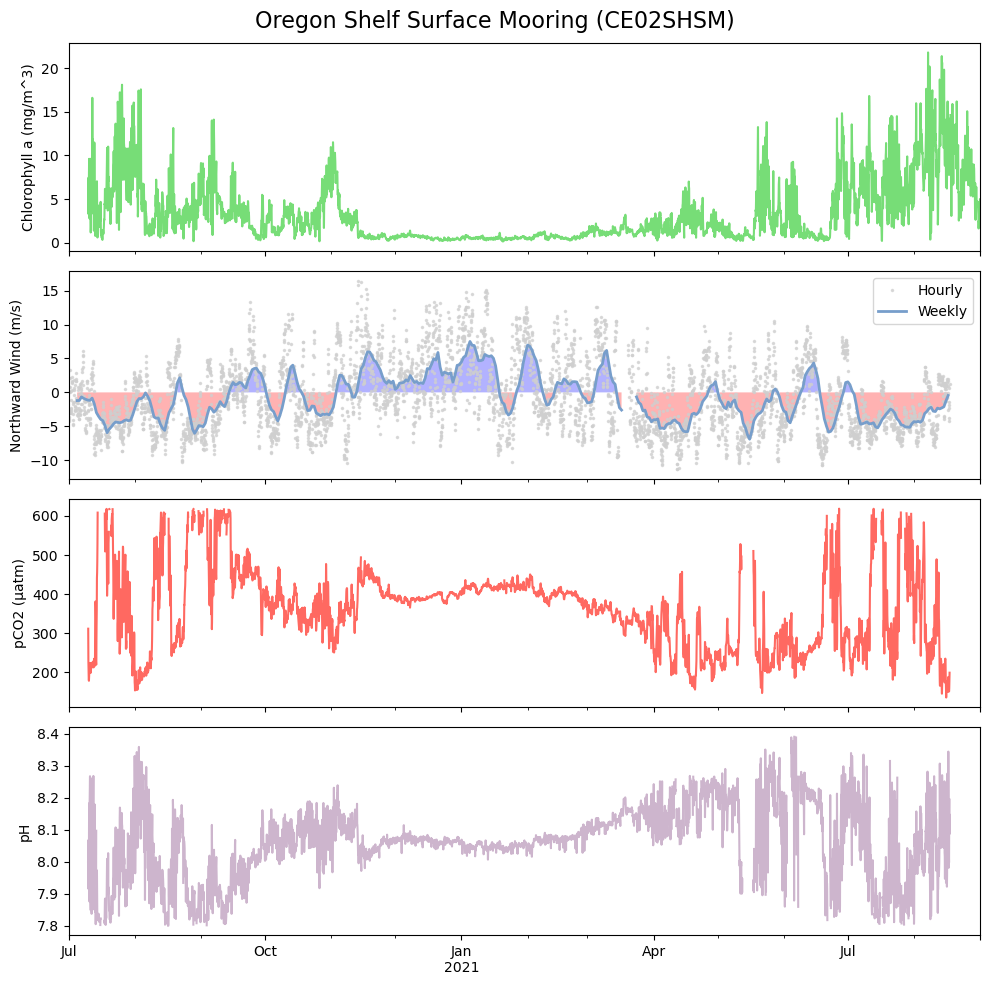

In [13]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

colors = {
    'chlorophyll': '#77dd77',  # pastel green
    'wind_hourly': '#cfcfcf',  # light grey
    'wind_daily': '#aec6cf',   # pastel blue
    'wind_weekly': '#779ecb',  # medium pastel blue
    'pco2': '#ff6961',         # pastel red
    'ph': '#cdb5cd'            # pastel purple
}

# Plot hourly datasets with semantic colors
df_combined_hourly['mass_concentration_of_chlorophyll_a_in_sea_water'].plot(ax=ax[0], color=colors['chlorophyll'])
df_combined_hourly['surface_partial_pressure_of_carbon_dioxide_in_sea_water'].plot(ax=ax[2], color=colors['pco2'])
df_combined_hourly['sea_water_ph_reported_on_total_scale'].plot(ax=ax[3], color=colors['ph'])

# Plot daily and weekly wind data on top of the hourly wind data
df_combined_hourly['northward_wind'].plot(ax=ax[1], color=colors['wind_hourly'], label='Hourly', alpha=0.7, style='.', markersize=3)
# df_metbk_hourly['northward_wind'].plot(ax=ax[1], color=colors['wind_hourly'], label='Hourly', alpha=0.5)
# df_metbk_daily['northward_wind'].plot(ax=ax[1], color=colors['wind_daily'], linestyle='--', label='Daily')
df_metbk_rolling['northward_wind'].plot(ax=ax[1], color=colors['wind_weekly'], linestyle='-', linewidth=2, label='Weekly')
ax[1].legend()

# Add shading for positive and negative wind periods
ax[1].fill_between(df_metbk_rolling.index, 0, df_metbk_rolling['northward_wind'], 
                   where=(df_metbk_rolling['northward_wind'] > 0), facecolor='blue', alpha=0.3, label='Positive Wind')
ax[1].fill_between(df_metbk_rolling.index, 0, df_metbk_rolling['northward_wind'], 
                   where=(df_metbk_rolling['northward_wind'] < 0), facecolor='red', alpha=0.3, label='Negative Wind')

# Add y labels and remove subplot titles
ax[0].set_ylabel('Chlorophyll a (mg/m^3)')
ax[1].set_ylabel('Northward Wind (m/s)')
ax[2].set_ylabel('pCO2 (µatm)')
ax[3].set_ylabel('pH')
ax[3].set_xlabel('')

# Add a figure title
fig.suptitle('Oregon Shelf Surface Mooring (CE02SHSM)', fontsize=16)

plt.tight_layout()
plt.show()

fig.savefig('data/lab11_ce02shsm_timeseries.png')

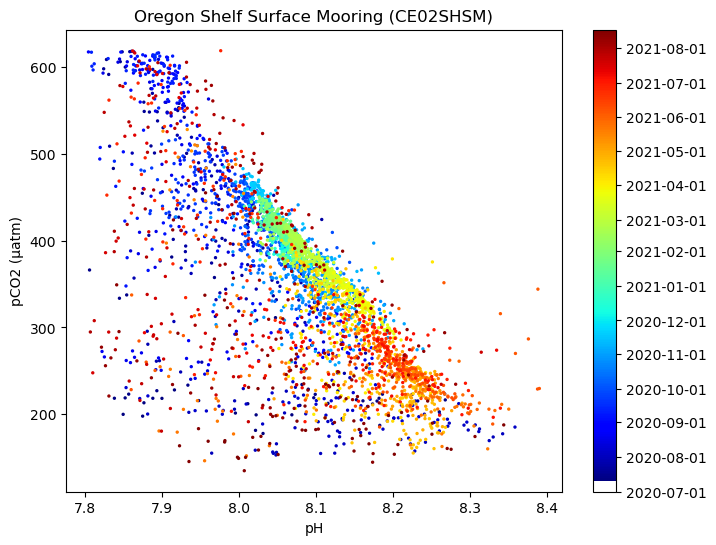

In [14]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 6))

# Create a scatter plot of pH vs pCO2 colored by time
sc = ax.scatter( 
    df_combined_hourly['sea_water_ph_reported_on_total_scale'], 
    df_combined_hourly['surface_partial_pressure_of_carbon_dioxide_in_sea_water'], 
    c=df_combined_hourly.index, 
    s=2,
    cmap='jet')

# Add a colorbar with date ticks
cbar = plt.colorbar(sc) #label='Date'
cbar.set_ticks(pd.date_range(start=df_combined_hourly.index.min(), end=df_combined_hourly.index.max(), freq='MS').astype(int))
ticks = cbar.get_ticks()
cbar.set_ticks(ticks)
# cbar.set_ticklabels(pd.to_datetime(ticks).strftime(date_format='%Y-%m-%d'))
cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%Y-%m-%d'));

# Set labels and title
ax.set_xlabel('pH')
ax.set_ylabel('pCO2 (µatm)')
ax.set_title('Oregon Shelf Surface Mooring (CE02SHSM)')

plt.show()
fig.savefig('data/lab11_ce02shsm_ph_pco2.png')

In [16]:
# Simplify variable names
df_export = df_combined_hourly.rename(columns={
    'mass_concentration_of_chlorophyll_a_in_sea_water': 'chlorophyll',
    'northward_wind': 'northward_wind',
    'surface_partial_pressure_of_carbon_dioxide_in_sea_water': 'pco2',
    'sea_water_ph_reported_on_total_scale': 'ph'
})

# Simplify time to just hour and reduce precision
df_export.index = df_export.index.strftime('%Y-%m-%d %H:00:00')
df_export = df_export.round(3)

# Export to CSV
df_export.to_csv('data/lab11_ce02shsm.csv')